<a href="https://colab.research.google.com/github/mohamedtal/PFE2021/blob/main/05_04_2021_task1_a_RGB_preprocessing2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
import os
import random
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.python.keras import Model
from tensorflow.python.keras.layers import Dense, Flatten
from tensorflow.keras import layers
from keras.applications.resnet50 import ResNet50
from keras.applications import DenseNet121
from keras.utils import Sequence
from keras.layers import Dense, Dropout, Flatten, Input, ZeroPadding2D, GlobalAveragePooling2D
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras import regularizers
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras import optimizers
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K
import tensorflow as tf

In [ ]:
# before all don't forget to use the GPU

# at first we need to get the dataset from the drive 
# pfe2021.1@gmail.com		zakimoha123
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [ ]:
#unzip the dataset

# for the train
!unzip /content/drive/MyDrive/dataset/DR-500-100-100.zip

In [ ]:
def preprocessFunction(image):
    #image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
    kopya = image.copy()
    kopya = cv2.cvtColor(kopya,cv2.COLOR_RGB2GRAY)
    blur = cv2.GaussianBlur(kopya,(5,5),0)
    thresh = cv2.threshold(blur,10,255,cv2.THRESH_BINARY)[1]
    kontur = cv2.findContours(thresh.copy(),cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    kontur = kontur[0][0]
    kontur = kontur[:,0,:]
    x1 = tuple(kontur[kontur[:,0].argmin()])[0]
    x2 = tuple(kontur[kontur[:,0].argmax()])[0]
    y1 = tuple(kontur[kontur[:,1].argmin()])[1]
    y2 = tuple(kontur[kontur[:,1].argmax()])[1]
    x = int(x2-x1)*4//50
    y = int(y2-y1)*5//50
    kopya2 = image.copy()
    if x2-x1>100 and y2-y1>100 :
        kopya2 = kopya2[y1+y:y2-y , x1+x:x2-x]
        kopya2 = cv2.resize(kopya2,(1024,1024))
    lab = cv2.cvtColor(kopya2,cv2.COLOR_RGB2LAB)
    l,a,b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=5.0,tileGridSize=((8,8)))
    cl = clahe.apply(l)
    limg = cv2.merge((cl,a,b))
    son = cv2.cvtColor(limg,cv2.COLOR_LAB2RGB)
    med_son = cv2.medianBlur(son,3)
    arka_plan = cv2.medianBlur(son,37)
    maske = cv2.addWeighted(med_son,1,arka_plan,-1,255)
    son_img = cv2.bitwise_and(maske,med_son)
    return son_img

In [ ]:
# creating the batches folder
path_batch_train = 'batchesTrain'
path_batch_test = 'batchesTest'
path_batch_val = 'batchesVal'

def createBatchFolder(pathName):
    try:
        os.mkdir(pathName)
    except OSError:
        print ("Creation of the directory %s failed" % pathName)
    else:
        print ("Successfully created the directory %s " % pathName)
    finally:
        for i in range(1,17):
          try:
              pathBatch = pathName+'/'+str(i)
              os.mkdir(pathBatch)
          except OSError:
              print ("Creation of the directory %s failed" % pathName)
          finally:
            for j in range(5):
              try:
                  pathClass = pathBatch+'/'+ str(j)
                  os.mkdir(pathClass)
              except OSError:
                  print ("Creation of the directory %s failed" % pathName)
# call the create path function
createBatchFolder(path_batch_train)
createBatchFolder(path_batch_test)
createBatchFolder(path_batch_val)


Successfully created the directory batchesTrain 
Successfully created the directory batchesTest 
Successfully created the directory batchesVal 


In [ ]:
!rm -r test/
!rm -r train/
!rm -r val/

In [ ]:
path_test = 'test'
path_train = 'train'
path_val = 'val'

def createBatchFolder(pathName):
    try:
        os.mkdir(pathName)
    except OSError:
        print ("Creation of the directory %s failed" % pathName)
    else:
        print ("Successfully created the directory %s " % pathName)
    finally:
        for i in range(5):
          try:
              pathBatch = pathName+'/'+str(i)
              os.mkdir(pathBatch)
          except OSError:
              print ("Creation of the directory %s failed" % pathName)

# call the create path function
createBatchFolder(path_train)
createBatchFolder(path_test)
createBatchFolder(path_val)

Successfully created the directory train 
Successfully created the directory test 
Successfully created the directory val 


In [ ]:
#read images, do division, save results batches
path = '/content/DR-500-100-100/train/'
new_path='train/'
numberImagesPerClass = 500
numberTestImagesPerClass = 100
numberValImagesPerClass = 100
size_batch = 32
sizeOfOriginalImage = 1024
numberOfClass = 5

def createBatches(path,new_path,numberImagesPerClass,sizeOfOriginalImage,numberOfClass):
    for c in range(numberOfClass):
      # the path of each class
      path_class = path + str(c)
      # get the list of images in each class
      list_images =  os.listdir(path_class)

      # get dataset
      for image in list_images:
        # get the path of each image
        path_image = path_class+'/'+ image
        # read the image
        img = cv2.imread(path_image)
        try:
          img = preprocessFunction(img)
        except:
          pass
        img = cv2.resize(img, dsize=(sizeOfOriginalImage, sizeOfOriginalImage))
        new_path_ = new_path+str(c)+'/'+image
        cv2.imwrite(new_path_,img)
        

createBatches(path,new_path,numberImagesPerClass,sizeOfOriginalImage,numberOfClass)

In [ ]:
from tensorflow import keras
import matplotlib.pyplot as plt

path = 'train/'
for c in range(5):
  new_path = path + str(c)
  list_images =  os.listdir(new_path)
  for img in list_images:
    image = cv2.imread(new_path+'/'+img)
    image = np.expand_dims(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), 0)

    data_generator = keras.preprocessing.image.ImageDataGenerator(zoom_range=0.15,rotation_range=0,fill_mode='constant')
    data_generator.fit(image)

    dir_It = data_generator.flow(
        image,
        batch_size=1,
        save_to_dir=new_path,
        save_prefix="",
        save_format='png',
    )

    for _ in range(2):
        img = dir_It.next()

In [ ]:
!ls train/0 | wc -l
!ls train/2 | wc -l

1450
1454


In [ ]:
#read images, do division, save results batches

size_batch = 255
sizeOfOriginalImage = 1024
numberOfClass = 5

def createBatches(path,path_batch,size_batch,sizeOfOriginalImage,numberOfClass):
    numberOfBatch = sizeOfOriginalImage // size_batch
    for c in range(numberOfClass):
      # the path of each class
      path_class = path + str(c)
      # get the list of images in each class
      list_images =  os.listdir(path_class)
      # get train dataset
      for image in list_images:
        path_image = path_class+'/'+ image
        # read the image
        img = cv2.imread(path_image)
        numeroBatch = 1
        for i in range(numberOfBatch):
          for j in range(numberOfBatch):
            batch = img[i*size_batch:i*size_batch+size_batch,j*size_batch:j*size_batch+size_batch,:]
            try:
                newPath = path_batch+'/'+str(numeroBatch)+'/'+str(c)+'/'+image
                cv2.imwrite(newPath,batch)
            except Exception as e:
                print(img.shape)
                print('error_train'+str(e))
            numeroBatch = numeroBatch + 1


createBatches('train/','batchesTrain',size_batch,sizeOfOriginalImage,numberOfClass)
createBatches('test/','batchesTest',size_batch,sizeOfOriginalImage,numberOfClass)
createBatches('val/','batchesVal',size_batch,sizeOfOriginalImage,numberOfClass)

In [ ]:
!zip batchesTrain -r batchesTrain/ {.zip}
!zip batchesTest -r batchesTest/ {.zip}
!zip batchesVal -r batchesVal/ {.zip}

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  adding: batchesVal/13/2/37017_left.jpg (deflated 1%)
  adding: batchesVal/13/2/2992_right.jpg (deflated 1%)
  adding: batchesVal/13/2/7263_right.jpg (deflated 1%)
  adding: batchesVal/13/2/40575_right.jpg (deflated 1%)
  adding: batchesVal/13/2/36865_right.jpg (deflated 1%)
  adding: batchesVal/13/2/7906_left.jpg (deflated 1%)
  adding: batchesVal/13/2/7640_left.jpg (deflated 1%)
  adding: batchesVal/13/2/8522_right.jpg (deflated 1%)
  adding: batchesVal/13/2/37528_left.jpg (deflated 1%)
  adding: batchesVal/13/2/13585_right.jpg (deflated 1%)
  adding: batchesVal/13/2/38127_right.jpg (deflated 2%)
  adding: batchesVal/13/2/43813_right.jpg (deflated 1%)
  adding: batchesVal/13/2/29352_right.jpg (deflated 1%)
  adding: batchesVal/13/2/22828_right.jpg (deflated 1%)
  adding: batchesVal/13/2/20634_right.jpg (deflated 1%)
  adding: batchesVal/13/2/18759_right.jpg (deflated 2%)
  adding: batchesVal/13/2/25983_rig

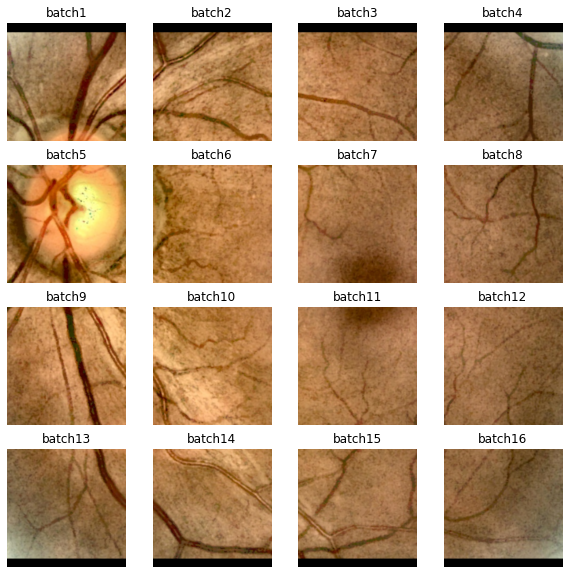

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


fig = plt.figure(figsize=(10, 10)) 
  
# setting values to rows and column variables 
rows = 4
columns = 4

for i in range(1,17):
  # Adds a subplot at the 1st position 
  image = mpimg.imread('batchesTrain/'+str(i)+'/0/_0_2788.png')
  image = cv2.resize(image,(224,224))
  fig.add_subplot(rows, columns, i) 
  # showing image 
  plt.imshow(image) 
  plt.axis('off') 
  plt.title("batch"+str(i)) 

In [ ]:
def createModel():
  pre_trained_model = DenseNet121(input_shape = (224,224,3), # Shape of our images
                                include_top = False, # Leave out the last fully connected layer
                                weights = 'imagenet')

  model = Sequential()
  model.add(pre_trained_model)
  model.add(GlobalAveragePooling2D())
  model.add(Dropout(0.5))
  model.add(Dense(5, activation='softmax'))

  model.compile(
      loss='categorical_crossentropy',
      optimizer=optimizers.Adam(lr=0.00005),
      metrics=['accuracy']
  )
  return model

batchesTrain/1/
Found 7270 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/30
227/227 [==============================] - 57s 208ms/step - loss: 2.1946 - accuracy: 0.2105 - val_loss: 1.6893 - val_accuracy: 0.2562

Epoch 00001: val_loss improved from inf to 1.68928, saving model to drive/MyDrive/models/predictionResultsBatches/modelBatch1.h5
Epoch 2/30
227/227 [==============================] - 45s 197ms/step - loss: 1.8463 - accuracy: 0.2916 - val_loss: 1.5723 - val_accuracy: 0.2854

Epoch 00002: val_loss improved from 1.68928 to 1.57227, saving model to drive/MyDrive/models/predictionResultsBatches/modelBatch1.h5
Epoch 3/30
227/227 [==============================] - 45s 197ms/step - loss: 1.6980 - accuracy: 0.3344 - val_loss: 1.5624 - val_accuracy: 0.3125

Epoch 00003: val_loss improved from 1.57227 to 1.56245, saving model to drive/MyDrive/models/predictionResultsBatches/modelBatch1.h5
Epoch 4/30
227/227 [==============================] - 45s 197ms/step - loss: 1.5530 - accuracy: 0.3855 - val_loss: 1.5439 - val_accuracy: 0.2979

Epoch 00004: val_loss

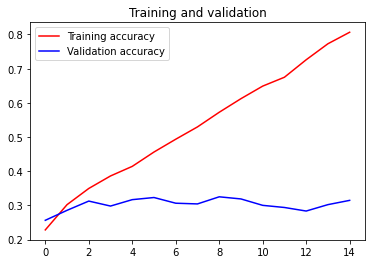

<Figure size 432x288 with 0 Axes>

100%|██████████| 14/14 [00:01<00:00,  8.46it/s]


[[18 40 31  6  3]
 [27 30 25  6  6]
 [19 28 26 10 14]
 [ 9 15 23 28 21]
 [11  4  8 24 48]]
              precision    recall  f1-score   support

           0       0.21      0.18      0.20        98
           1       0.26      0.32      0.28        94
           2       0.23      0.27      0.25        97
           3       0.38      0.29      0.33        96
           4       0.52      0.51      0.51        95

    accuracy                           0.31       480
   macro avg       0.32      0.31      0.31       480
weighted avg       0.32      0.31      0.31       480

batchesTrain/2/
Found 7270 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Epoch 1/30
227/227 [==============================] - 56s 205ms/step - loss: 2.2132 - accuracy: 0.2280 - val_loss: 1.6226 - val_accuracy: 0.2917

Epoch 00001: val_loss improved from inf to 1.62264, saving model to drive/MyDrive/models/predictionResultsBatches/modelBatch2.h5
Epoch 2/30
227/227 [==========================

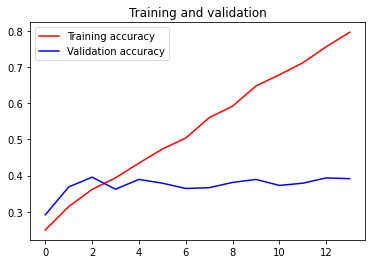

<Figure size 432x288 with 0 Axes>

100%|██████████| 14/14 [00:01<00:00, 10.21it/s]


[[26 31 26  7  6]
 [28 30 19 13  6]
 [18 18 31 18 13]
 [13  5 18 40 19]
 [ 5  4 13 18 55]]
              precision    recall  f1-score   support

           0       0.29      0.27      0.28        96
           1       0.34      0.31      0.33        96
           2       0.29      0.32      0.30        98
           3       0.42      0.42      0.42        95
           4       0.56      0.58      0.57        95

    accuracy                           0.38       480
   macro avg       0.38      0.38      0.38       480
weighted avg       0.38      0.38      0.38       480

batchesTrain/3/
Found 7270 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Epoch 1/30
227/227 [==============================] - 56s 204ms/step - loss: 2.1315 - accuracy: 0.2403 - val_loss: 1.6235 - val_accuracy: 0.3042

Epoch 00001: val_loss improved from inf to 1.62350, saving model to drive/MyDrive/models/predictionResultsBatches/modelBatch3.h5
Epoch 2/30
227/227 [==========================

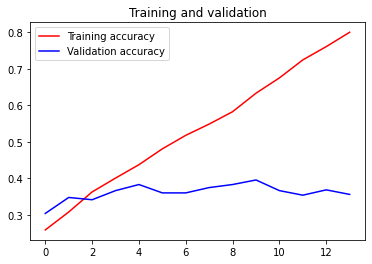

<Figure size 432x288 with 0 Axes>

100%|██████████| 14/14 [00:01<00:00,  9.77it/s]


[[36 32 13  7  9]
 [24 37 20 10  6]
 [18 32 14 14 17]
 [10 13 11 36 25]
 [ 6  8 13 18 51]]
              precision    recall  f1-score   support

           0       0.38      0.37      0.38        97
           1       0.30      0.38      0.34        97
           2       0.20      0.15      0.17        95
           3       0.42      0.38      0.40        95
           4       0.47      0.53      0.50        96

    accuracy                           0.36       480
   macro avg       0.36      0.36      0.36       480
weighted avg       0.36      0.36      0.36       480

batchesTrain/4/
Found 7270 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Epoch 1/30
227/227 [==============================] - 56s 204ms/step - loss: 2.1876 - accuracy: 0.2343 - val_loss: 1.6278 - val_accuracy: 0.2646

Epoch 00001: val_loss improved from inf to 1.62782, saving model to drive/MyDrive/models/predictionResultsBatches/modelBatch4.h5
Epoch 2/30
227/227 [==========================

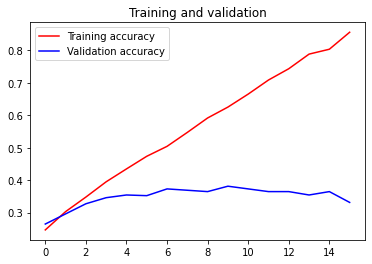

<Figure size 432x288 with 0 Axes>

100%|██████████| 14/14 [00:01<00:00, 10.38it/s]


[[31 31 21  7  5]
 [26 28 23  9  8]
 [22 26 17 16 15]
 [10 14 22 31 21]
 [ 7  8 13 16 53]]
              precision    recall  f1-score   support

           0       0.32      0.33      0.32        95
           1       0.26      0.30      0.28        94
           2       0.18      0.18      0.18        96
           3       0.39      0.32      0.35        98
           4       0.52      0.55      0.53        97

    accuracy                           0.33       480
   macro avg       0.33      0.33      0.33       480
weighted avg       0.34      0.33      0.33       480

batchesTrain/5/
Found 7270 images belonging to 5 classes.
Found 500 images belonging to 5 classes.
Epoch 1/30
227/227 [==============================] - 57s 207ms/step - loss: 2.2751 - accuracy: 0.2108 - val_loss: 1.6593 - val_accuracy: 0.2729

Epoch 00001: val_loss improved from inf to 1.65930, saving model to drive/MyDrive/models/predictionResultsBatches/modelBatch5.h5
Epoch 2/30
227/227 [==========================

KeyboardInterrupt: ignored

In [ ]:
# create 16 models using the densenet architecture
# at first create the model
from keras.preprocessing.image import ImageDataGenerator
import numpy
import math
for i in range(1,17):
  batchSize = 32
  pathBatch = 'batchesTrain'+'/'+str(i)+'/'
  print(pathBatch)
  # ******** for train dataset

  train_datagen = ImageDataGenerator(
      rescale=1./255,
      ) 

  train_generator = train_datagen.flow_from_directory(
        pathBatch,
        classes = ['0','1','2','3','4'],
        target_size=(224, 224),
        color_mode='rgb',
        batch_size=32,
        class_mode='categorical',
        shuffle=True)

    # ******* for validation dataset
  val_datagen = ImageDataGenerator(
        rescale=1./255,
        ) 

  val_generator = val_datagen.flow_from_directory(
        'batchesVal'+'/'+str(i)+'/',
        classes = ['0','1','2','3','4'],
        target_size=(224, 224),
        color_mode='rgb',
        batch_size=batchSize,
        class_mode='categorical')
  model = createModel()
  # 
  earlystopper = EarlyStopping(
            monitor = "val_loss",
            mode="min",
            patience=10,
            verbose=1
  )
  model_checkpoint = ModelCheckpoint(
              'drive/MyDrive/models/predictionResultsBatches/modelBatch'+str(i)+'.h5',
              monitor='val_loss',
              verbose=1,
              save_best_only=True
  )
  model.compile(optimizer=optimizers.Adam(lr=1e-5),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
  #history = numpy.empty(16, dtype=object)
  history = model.fit_generator(
    train_generator,
    steps_per_epoch=math.ceil(train_generator.samples//batchSize),
    epochs=30,
    validation_data = val_generator,
    validation_steps = math.ceil(val_generator.samples//batchSize),callbacks=[model_checkpoint,earlystopper],
    verbose = 1)
  import matplotlib.pyplot as plt
  %matplotlib inline

  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'r', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  #plt.plot(epochs, loss, 'g', label='Training loss')
  #plt.plot(epochs, val_loss, 'y', label='Validation loss')
  plt.title('Training and validation')
  plt.legend(loc=0)
  plt.figure()
  plt.savefig('results/batch'+str(i)+'.png')
  plt.show()

  from tqdm import tqdm
  # Store the data in X_train, y_train variables by iterating over the batches
  val_generator.reset()
  x_test, y_test = next(val_generator)
  for i in tqdm(range(int(val_generator.samples/batchSize)-1)): #1st batch is alread fetched before the for loop
    img, label = next(val_generator)
    x_test = np.append(x_test, img, axis=0 )
    y_test = np.append(y_test, label, axis=0)
  # do the predictions
  y_predicted = model.predict(x_test)
  y_pred = np.argmax(y_predicted, axis=1)

  import matplotlib.pyplot as plt
  from sklearn.metrics import confusion_matrix,classification_report
  font = {
  'family': 'Times New Roman',
  'size': 12
  }
  plt.rc('font', **font)
  mat = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
  print(mat)
  #class_labels = list(val_generator.class_indices.keys())
  class_labels=['0','1','2','3','4']
  report = classification_report(np.argmax(y_test,axis=1), y_pred, target_names=class_labels)
  print(report)


#Test

In [ ]:


from tensorflow import keras
# function to predict classes of given batches usin the given model
def predictBatch(pathModel,pathTest):
  # load the model 
  from tensorflow import keras
  model = keras.models.load_model(pathModel)
  import numpy as np
  # read images
  test_datagen = ImageDataGenerator(
    #preprocessing_function = preprocessFunction,
    rescale=1./255)
  test_generator = test_datagen.flow_from_directory(
    pathTest,
    classes = ['0','1','2','3','4'],
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=False)


  from tqdm import tqdm
  # Store the data in X_train, y_train variables by iterating over the batches
  test_generator.reset()
  x_test, y_test = next(test_generator)
  for i in tqdm(range(int(test_generator.samples/32)-1)): #1st batch is alread fetched before the for loop
    img, label = next(test_generator)
    x_test = np.append(x_test, img, axis=0 )
    y_test = np.append(y_test, label, axis=0)

  # do the predictions
  y_predicted = model.predict(x_test)
  y_pred = np.argmax(y_predicted, axis=1)
  return y_pred

# function to read images by batch
def readImagesBatch(pathBatch,number_class):
  for i in range(number_class):
    newPath = pathBatch+'/'+ str(i)
    list_dir =  os.listdir(newPath)
    images = []
    for image in list_dir:
      img = cv2.imread(newPath+'/'+image)
      img = cv2.resize(img, dsize=(244, 244))
      images.append(img)
    return images

# to get images information we need only one batch (because one batch contains all images)
def getImagesInformations(pathFirstBatch):
  img_name = []
  img_class = np.zeros((500,18), dtype=int)
  for i in range(5):
    newPath = pathFirstBatch + str(i)
    list_dir =  os.listdir(newPath)
    j = 499
    for image in list_dir:
      img_name.append(image)
      img_class[j][0] = i
      j = j-1
    return img_name,img_class

# at first we need to get the test images name and the equivalent class label
pathFirstBatch = 'batchesTest/1/'
img_name,img_class = getImagesInformations(pathFirstBatch)
# secondly, we need to predict the label of each batch
path = 'batchesTest/'
pathModels = '/content/drive/MyDrive/models/task1-a-RGB/modelBatch'
for i in range(1,17):
  # path to the model
  pathModel = pathModels+str(i)+'.h5'
  # read images
  pathBatch = path+str(i)
  #images = readImagesBatch(pathBatch,5)
  # use the predict function
  y_predicted = predictBatch(pathModel,pathBatch)
  # add y_predicted to our vector of results
  img_class[:,i] = y_predicted
print(img_class)

Found 500 images belonging to 5 classes.


0it [00:00, ?it/s]


Found 500 images belonging to 5 classes.


0it [00:00, ?it/s]


Found 500 images belonging to 5 classes.


0it [00:00, ?it/s]


Found 500 images belonging to 5 classes.


0it [00:00, ?it/s]


Found 500 images belonging to 5 classes.


0it [00:00, ?it/s]


Found 500 images belonging to 5 classes.


0it [00:00, ?it/s]


Found 500 images belonging to 5 classes.


0it [00:00, ?it/s]


Found 500 images belonging to 5 classes.


0it [00:00, ?it/s]


Found 500 images belonging to 5 classes.


0it [00:00, ?it/s]


Found 500 images belonging to 5 classes.


0it [00:00, ?it/s]


Found 500 images belonging to 5 classes.


0it [00:00, ?it/s]


Found 500 images belonging to 5 classes.


0it [00:00, ?it/s]


Found 500 images belonging to 5 classes.


0it [00:00, ?it/s]


Found 500 images belonging to 5 classes.


0it [00:00, ?it/s]


Found 500 images belonging to 5 classes.


0it [00:00, ?it/s]


Found 500 images belonging to 5 classes.


0it [00:00, ?it/s]


[[0 1 2 ... 0 0 0]
 [0 0 1 ... 0 2 0]
 [0 0 1 ... 1 3 0]
 ...
 [0 4 3 ... 2 2 0]
 [0 2 4 ... 3 4 0]
 [0 2 4 ... 4 4 0]]


In [ ]:
# save the results of predicting
with open('test.npy', 'wb') as f:
    np.save(f, img_class)
# save the name of images
import json
with open('test.txt', 'w') as f:
    f.write(json.dumps(img_name))


In [ ]:
# read the predicted numpy array
with load('test.npy') as data:
    img_class = data
#Now read the file back into a Python list object
with open('test.txt', 'r') as f:
    img_name = json.loads(f.read())


In [ ]:
classes = np.zeros((500,18), dtype=int)
# vote majoritaire
for i in range(len(img_class)):
  y_predicted = img_class[i,1:16]
  y_predicted = y_predicted.tolist()
  combinaison = []
  for j in range(5):
    combinaison.append(y_predicted.count(j))
  max_value = max(combinaison)
  max_index = combinaison.index(max_value)
  img_class[i,17]= max_index
print(img_class[:,17])

[0 2 1 0 4 0 0 2 1 0 1 1 4 0 1 0 0 2 1 2 4 0 0 1 1 1 1 0 0 2 1 0 1 0 1 2 1
 1 2 0 1 1 1 0 0 2 0 1 1 2 1 0 1 0 1 1 1 1 2 2 1 0 0 0 1 1 2 1 0 0 0 0 1 0
 0 3 2 1 3 0 1 0 2 2 1 1 1 4 0 0 1 0 1 2 4 0 1 0 1 0 1 1 0 2 2 0 0 1 1 2 2
 1 2 0 1 0 2 1 1 2 0 0 1 1 0 2 1 1 0 1 1 1 0 0 1 0 0 1 1 1 1 0 1 2 1 1 1 2
 0 1 1 1 0 0 0 1 0 0 3 3 1 2 2 1 0 0 3 1 0 1 1 0 1 0 2 0 2 0 1 1 1 0 0 3 2
 1 1 3 0 0 4 0 0 0 2 2 1 0 3 2 2 2 3 4 0 4 2 2 0 1 0 3 2 0 1 2 1 2 3 0 3 0
 2 0 1 2 2 1 3 2 1 3 2 1 1 1 4 4 2 2 0 1 0 1 0 0 1 2 1 0 0 1 4 1 2 4 1 0 3
 1 3 2 4 3 0 0 4 3 2 2 3 0 0 2 3 3 0 1 4 2 1 0 1 0 1 0 2 4 3 3 2 0 4 2 1 2
 2 2 4 2 3 4 3 3 3 1 3 2 3 3 3 3 3 3 3 3 0 3 1 3 1 3 3 3 3 3 1 3 2 3 2 2 3
 3 0 3 0 4 2 3 3 3 2 3 4 2 1 3 3 4 3 1 4 3 2 2 4 3 1 3 3 1 3 3 3 3 3 2 0 3
 2 3 3 1 3 3 3 4 3 3 4 3 3 3 4 3 2 3 4 2 2 1 3 3 1 3 2 3 3 4 4 4 4 4 3 3 4
 4 4 4 4 2 4 4 3 4 2 4 0 1 4 2 3 4 4 4 4 4 4 4 4 4 4 2 4 3 4 4 3 4 4 4 4 4
 4 4 1 3 4 3 4 4 1 4 3 2 1 4 0 3 1 4 3 4 4 4 4 3 4 2 4 3 4 4 2 3 4 4 4 4 4
 4 2 3 4 3 2 3 4 4 3 4 3 

In [ ]:
y_true = img_class[:,0]
y_true[100:199] = 1
y_true[200:299] = 2
y_true[300:399] = 3
y_true[400:499] = 4
y_pred = img_class[:,17]
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report
font = {
'family': 'Times New Roman',
'size': 12
}
plt.rc('font', **font)
mat = confusion_matrix(y_true, y_pred)
print(mat)
report = classification_report(y_true, y_pred, target_names=['0','1','2','3','4'])
print(report)

[[37 40 18  2  7]
 [35 40 17  6  1]
 [23 22 27 15 12]
 [ 4 11 15 59 10]
 [ 2  5  9 20 63]]
              precision    recall  f1-score   support

           0       0.37      0.36      0.36       104
           1       0.34      0.40      0.37        99
           2       0.31      0.27      0.29        99
           3       0.58      0.60      0.59        99
           4       0.68      0.64      0.66        99

    accuracy                           0.45       500
   macro avg       0.46      0.45      0.45       500
weighted avg       0.45      0.45      0.45       500



# testing the model evaluation for only one batch

In [ ]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/models/task1-a-RGB/modelBatch6.h5')
import numpy as np
# read images
test_datagen = ImageDataGenerator(
  #preprocessing_function = preprocessFunction,
  rescale=1./255)
test_generator = test_datagen.flow_from_directory(
  'batchesTest/6',
  classes = ['0','1','2','3','4'],
  target_size=(224, 224),
  color_mode='rgb',
  batch_size=500,
  class_mode='categorical',
  shuffle=False)

Found 500 images belonging to 5 classes.


In [ ]:
from tqdm import tqdm
# Store the data in X_train, y_train variables by iterating over the batches
test_generator.reset()
x_test, y_test = next(test_generator)
for i in tqdm(range(int(test_generator.samples/500)-1)): #1st batch is alread fetched before the for loop
  img, label = next(test_generator)
  x_test = np.append(x_test, img, axis=0 )
  y_test = np.append(y_test, label, axis=0)

# do the predictions
y_predicted = model.predict(x_test)
y_pred = np.argmax(y_predicted, axis=1)

0it [00:00, ?it/s]


In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,classification_report
font = {
'family': 'Times New Roman',
'size': 12
}
plt.rc('font', **font)
mat = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
print(mat)
report = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=['0','1','2','3','4'])
print(report)

[[25 25 29 12  9]
 [24 30 20 21  5]
 [14 23 26 19 18]
 [ 5 14 15 41 25]
 [ 4  5 11 32 48]]
              precision    recall  f1-score   support

           0       0.35      0.25      0.29       100
           1       0.31      0.30      0.30       100
           2       0.26      0.26      0.26       100
           3       0.33      0.41      0.36       100
           4       0.46      0.48      0.47       100

    accuracy                           0.34       500
   macro avg       0.34      0.34      0.34       500
weighted avg       0.34      0.34      0.34       500



#test vote approche (for BY)

In [ ]:
y_predicted = [0,0,1,1,1,1,2,2,2,2,0,0,0,3,3,4,4,4,4,4,4,4,4]
#y_predicted = y_predicted.tolist()
combinaison = []
for j in range(5):
  combinaison.append(y_predicted.count(j))
max_value = max(combinaison)
max_index = combinaison.index(max_value)
print(combinaison)
print(+max_index)

[5, 4, 4, 2, 8]
4


ground truth : 0
predicted class : 0
[0 1 2 0 2 0 1 1 4 0 0 0 0 3 0 0 0 0]


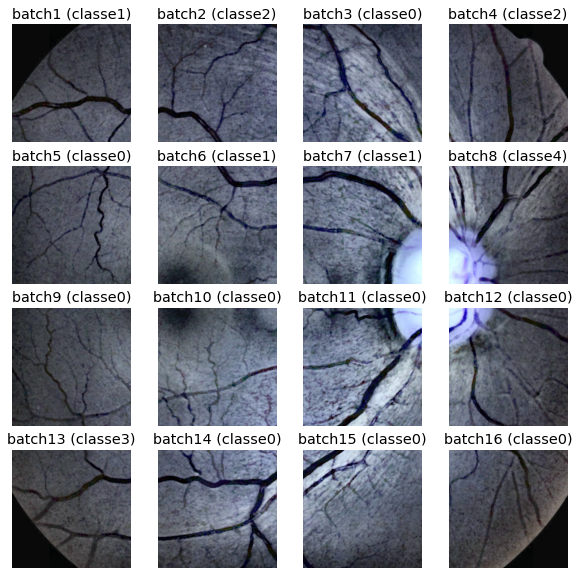

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


fig = plt.figure(figsize=(10, 10)) 
  
# setting values to rows and column variables 
rows = 4
columns = 4

pathModels = '/content/drive/MyDrive/models/task1-a-RGB/modelBatch'
for i in range(1,17):
  pathModel = pathModels+str(i)+'.h5'
  #model = keras.models.load_model(pathModel)
  # Adds a subplot at the 1st position 
  image = cv2.imread('batchesTest/'+str(i)+'/0/10773_right.jpg')
  fig.add_subplot(rows, columns, i) 
  # showing image 
  plt.imshow(image) 
  plt.axis('off') 

  plt.title("batch"+str(i)+" (classe"+str(img_class[0,i])+")") 

print("ground truth :",img_class[0,0])
print("predicted class :",img_class[0,17])
print(img_class[0,1:16])

ground truth : 0
predicted class : 2
[0 2 2 1 4 2 2 4 3 3 4 1 1 2 0 1 3 2]


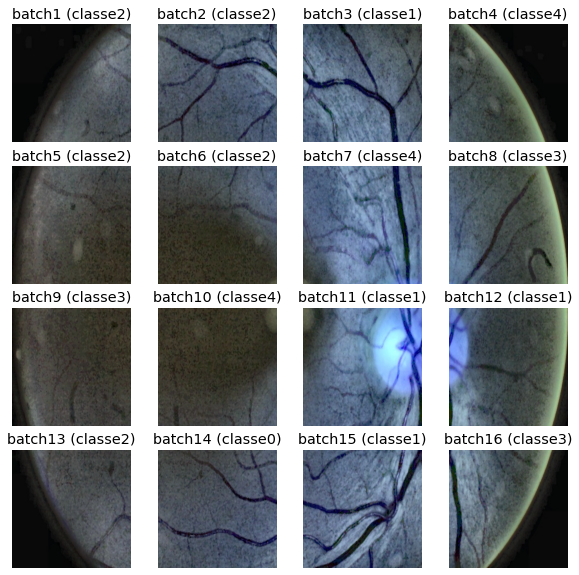

In [ ]:
fig = plt.figure(figsize=(10, 10)) 
  
# setting values to rows and column variables 
rows = 4
columns = 4

pathModels = '/content/drive/MyDrive/models/task1-a-RGB/modelBatch'
for i in range(1,17):
  pathModel = pathModels+str(i)+'.h5'
  #model = keras.models.load_model(pathModel)
  # Adds a subplot at the 1st position 
  image = cv2.imread('batchesTest/'+str(i)+'/0/14432_left.jpg')
  fig.add_subplot(rows, columns, i) 
  # showing image 
  plt.imshow(image) 
  plt.axis('off') 

  plt.title("batch"+str(i)+" (classe"+str(img_class[7,i])+")") 

print("ground truth :",img_class[7,0])
print("predicted class :",img_class[7,17])
print(img_class[7,1:16])

In [ ]:
print(len(img_name))

100


ground truth : 0
predicted class : 4
[0 2 4 0 3 3 4 4 4 4 0 4 4 1 4 4 1 4]


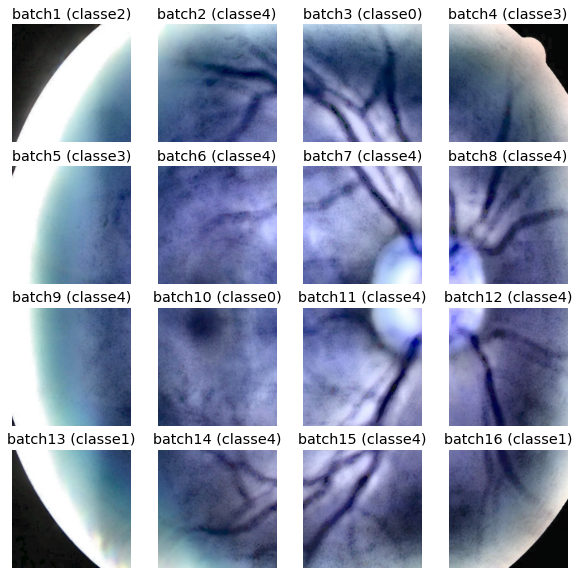

In [ ]:
fig = plt.figure(figsize=(10, 10)) 
  
# setting values to rows and column variables 
rows = 4
columns = 4

pathModels = '/content/drive/MyDrive/models/task1-a-RGB/modelBatch'
for i in range(1,17):
  pathModel = pathModels+str(i)+'.h5'
  #model = keras.models.load_model(pathModel)
  # Adds a subplot at the 1st position 
  image = cv2.imread('batchesTest/'+str(i)+'/0/13328_right.jpg')
  fig.add_subplot(rows, columns, i) 
  # showing image 
  plt.imshow(image) 
  plt.axis('off') 

  plt.title("batch"+str(i)+" (classe"+str(img_class[4,i])+")") 

print("ground truth :",img_class[4,0])
print("predicted class :",img_class[4,17])
print(img_class[4,1:16])

# test all the model above one batch

In [ ]:
test_batch = 'batchesTest/1/'
path_model = '/content/drive/MyDrive/models/task1-a-RGB/modelBatch'

# read test data into image data generator object
import numpy as np
# read images
test_datagen = ImageDataGenerator(
  #preprocessing_function = preprocessFunction,
  rescale=1./255)
test_generator = test_datagen.flow_from_directory(
  test_batch,
  classes = ['0','1','2','3','4'],
  target_size=(224, 224),
  color_mode='rgb',
  batch_size=500,
  class_mode='categorical',
  shuffle=False)
for i in range(1,17):
  # get the path to the model 
  path_model_batch = path_model + str(i)+ '.h5'
  # load the model 
  from tensorflow import keras
  model=keras.models.load_model(path_model_batch)
  print(" ********************* model "+str(i)+" *********************")
  from tqdm import tqdm
  # Store the data in X_train, y_train variables by iterating over the batches
  test_generator.reset()
  x_test, y_test = next(test_generator)
  # do the predictions
  y_predicted = model.predict(x_test)
  y_pred = np.argmax(y_predicted, axis=1)

  # trace the confusion matrix
  import matplotlib.pyplot as plt
  from sklearn.metrics import confusion_matrix,classification_report
  font = {
  'family': 'Times New Roman',
  'size': 12
  }
  plt.rc('font', **font)
  mat = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
  print(mat)
  report = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=['0','1','2','3','4'])
  print(report)

Found 500 images belonging to 5 classes.
 ********************* model 1 *********************
[[36 34 18  5  7]
 [21 45 21  6  7]
 [25 19 28 17 11]
 [ 7  4  9 73  7]
 [ 1  1  6  7 85]]
              precision    recall  f1-score   support

           0       0.40      0.36      0.38       100
           1       0.44      0.45      0.44       100
           2       0.34      0.28      0.31       100
           3       0.68      0.73      0.70       100
           4       0.73      0.85      0.78       100

    accuracy                           0.53       500
   macro avg       0.52      0.53      0.52       500
weighted avg       0.52      0.53      0.52       500

 ********************* model 2 *********************
[[23 26 30 14  7]
 [22 26 27 11 14]
 [16 24 26 26  8]
 [12  6 25 37 20]
 [ 5  9 14 15 57]]
              precision    recall  f1-score   support

           0       0.29      0.23      0.26       100
           1       0.29      0.26      0.27       100
           2       

# test one model over all the batches

In [ ]:
#load the model
model = '/content/drive/MyDrive/models/task1-a-RGB/modelBatch14.h5'
test_batch = 'batchesTest/'
from tensorflow import keras
model=keras.models.load_model(path_model_batch)
for i in range(1,17):
  # load the data
  print("*******************  batch "+str(i)+" ****************")
  path_batch = test_batch + str(i)
  test_datagen = ImageDataGenerator(
  #preprocessing_function = preprocessFunction,
  rescale=1./255)
  test_generator = test_datagen.flow_from_directory(
  path_batch,
  classes = ['0','1','2','3','4'],
  target_size=(224, 224),
  color_mode='rgb',
  batch_size=500,
  class_mode='categorical',
  shuffle=False)

  # do the predictions
  from tqdm import tqdm
  # Store the data in X_train, y_train variables by iterating over the batches
  test_generator.reset()
  x_test, y_test = next(test_generator)
  # do the predictions
  y_predicted = model.predict(x_test)
  y_pred = np.argmax(y_predicted, axis=1)

  # trace the confusion matrix
  import matplotlib.pyplot as plt
  from sklearn.metrics import confusion_matrix,classification_report
  font = {
  'family': 'Times New Roman',
  'size': 12
  }
  plt.rc('font', **font)
  mat = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
  print(mat)
  report = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=['0','1','2','3','4'])
  print(report)

*******************  batch 1 ****************
Found 500 images belonging to 5 classes.
[[14 46 15 10 15]
 [25 46 11  9  9]
 [23 22 21 15 19]
 [ 9 20 16 30 25]
 [ 9 15  6  9 61]]
              precision    recall  f1-score   support

           0       0.17      0.14      0.16       100
           1       0.31      0.46      0.37       100
           2       0.30      0.21      0.25       100
           3       0.41      0.30      0.35       100
           4       0.47      0.61      0.53       100

    accuracy                           0.34       500
   macro avg       0.33      0.34      0.33       500
weighted avg       0.33      0.34      0.33       500

*******************  batch 2 ****************
Found 500 images belonging to 5 classes.
[[24 41 17  7 11]
 [29 49 11  8  3]
 [18 41 17 13 11]
 [ 8 17 14 31 30]
 [ 6  9  7 15 63]]
              precision    recall  f1-score   support

           0       0.28      0.24      0.26       100
           1       0.31      0.49      0.38   

In [ ]:
#load the model
model = '/content/drive/MyDrive/models/task1-a-RGB/modelBatch2.h5'
test_batch = 'batchesTest/'
from tensorflow import keras
model=keras.models.load_model(path_model_batch)
for i in range(1,17):
  # load the data
  print("*******************  batch "+str(i)+" ****************")
  path_batch = test_batch + str(i)
  test_datagen = ImageDataGenerator(
  #preprocessing_function = preprocessFunction,
  rescale=1./255)
  test_generator = test_datagen.flow_from_directory(
  path_batch,
  classes = ['0','1','2','3','4'],
  target_size=(224, 224),
  color_mode='rgb',
  batch_size=500,
  class_mode='categorical',
  shuffle=False)

  # do the predictions
  from tqdm import tqdm
  # Store the data in X_train, y_train variables by iterating over the batches
  test_generator.reset()
  x_test, y_test = next(test_generator)
  # do the predictions
  y_predicted = model.predict(x_test)
  y_pred = np.argmax(y_predicted, axis=1)

  # trace the confusion matrix
  import matplotlib.pyplot as plt
  from sklearn.metrics import confusion_matrix,classification_report
  font = {
  'family': 'Times New Roman',
  'size': 12
  }
  plt.rc('font', **font)
  mat = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
  print(mat)
  report = classification_report(np.argmax(y_test, axis=1), y_pred, target_names=['0','1','2','3','4'])
  print(report)

*******************  batch 1 ****************
Found 500 images belonging to 5 classes.
[[14 46 15 10 15]
 [25 46 11  9  9]
 [23 22 21 15 19]
 [ 9 20 16 30 25]
 [ 9 15  6  9 61]]
              precision    recall  f1-score   support

           0       0.17      0.14      0.16       100
           1       0.31      0.46      0.37       100
           2       0.30      0.21      0.25       100
           3       0.41      0.30      0.35       100
           4       0.47      0.61      0.53       100

    accuracy                           0.34       500
   macro avg       0.33      0.34      0.33       500
weighted avg       0.33      0.34      0.33       500

*******************  batch 2 ****************
Found 500 images belonging to 5 classes.
[[24 41 17  7 11]
 [29 49 11  8  3]
 [18 41 17 13 11]
 [ 8 17 14 31 30]
 [ 6  9  7 15 63]]
              precision    recall  f1-score   support

           0       0.28      0.24      0.26       100
           1       0.31      0.49      0.38   